In [4]:
import numpy as np
import pandas as pd
import torch
import pickle
# !pip install transformers --quiet

## dataframe

##save and load dataframe

In [78]:
## save the dataset


# file_path = '/content/drive/My Drive/recpie2video/youcook.pkl'

# with open(file_path, 'wb') as file:
#     pickle.dump(df, file)


In [10]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [14]:
!gpustat

user                 Thu Oct 12 07:38:34 2023  470.82.01
[0] Quadro RTX 4000  | 32'C,   0 % |  5135 /  7979 MB | elidandi_2211ai08(4961M) gdm(39M) user(82M) user(31M)


In [6]:
import torch
torch.cuda.is_available()

False

In [1]:
import pickle

file_path = '/DATA/elidandi_2211ai08/Reciepe2video/youcook2/youcook.pkl'

try:
    with open(file_path, 'rb') as file:
        df = pickle.load(file)
#         if isinstance(df, torch.Tensor):
#             df = df.to('cpu')
#         elif isinstance(df, dict):
#             for key in df:
#                 if isinstance(df[key], torch.Tensor):
#                     df[key] = df[key].to('cpu')

    print("Successfully loaded the pickled data.")
except FileNotFoundError:
    print(f"File not found at '{file_path}'. Please check the file path.")
except EOFError:
    print("EOFError: Ran out of input. The file may be empty or corrupted.")
except Exception as e:
    print(f"An error occurred: {str(e)}")


Successfully loaded the pickled data.


In [2]:
df.head()

,Recipe,subset,recipe_type,segment,sentence,url,embeding
0,GLd3aX16zBg,training,113,"[90, 102]",spread margarine on two slices of white bread,https://www.youtube.com/watch?v=GLd3aX16zBg,"[tensor(-0.1793, device='cuda:0'), tensor(0.44..."
1,GLd3aX16zBg,training,113,"[114, 127]",place a slice of cheese on the bread,https://www.youtube.com/watch?v=GLd3aX16zBg,"[tensor(-0.4276, device='cuda:0'), tensor(0.39..."
2,GLd3aX16zBg,training,113,"[132, 138]",place the bread slices on top of each other an...,https://www.youtube.com/watch?v=GLd3aX16zBg,"[tensor(-0.3283, device='cuda:0'), tensor(0.51..."
3,GLd3aX16zBg,training,113,"[139, 145]",flip the sandwich over and press down,https://www.youtube.com/watch?v=GLd3aX16zBg,"[tensor(-0.0702, device='cuda:0'), tensor(0.45..."
4,GLd3aX16zBg,training,113,"[173, 174]",cut the sandwich in half diagonally,https://www.youtube.com/watch?v=GLd3aX16zBg,"[tensor(0.0727, device='cuda:0'), tensor(0.517..."


## text similarities

In [1]:
!pip install -U sentence_transformers

/bin/bash: pip: command not found


In [10]:

from sentence_transformers import SentenceTransformer,util
# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Load a pre-trained Sentence Transformer model and move it to the GPU
model_name = "paraphrase-MiniLM-L6-v2"
model = SentenceTransformer(model_name)
model.to(device)

ModuleNotFoundError: No module named 'sentence_transformers'

In [21]:
# def similarity_mapping(text):
#   input_emb = model.encode(NER_classification(text), convert_to_tensor=True).cpu()
#   result=[[cosine_similarity(df.iloc[i]['embeding'], input_emb).item(), df.loc[i]['sentence'], i] for i in range(len(df))]
#   collection=sorted(result, key=lambda x: x[0], reverse=True)[:5]
#   return collection

In [65]:
collection = similarity_mapping("cut the sandwitch into half")

In [68]:
collection

[[7054, 0.8808058500289917, 'spread butter over a slice of bread'],
 [12246, 0.8736963868141174, 'spread butter on a slice of bread'],
 [5929, 0.8469002842903137, 'spread butter onto a piece of french bread'],
 [5934, 0.8422383069992065, 'spread butter on the top piece of bread'],
 [8768, 0.8383846879005432, 'spread butter on both slices of bread']]

## NER


In [5]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline
tokenizer = AutoTokenizer.from_pretrained("Dizex/InstaFoodBERT-NER")
model_ner = AutoModelForTokenClassification.from_pretrained("Dizex/InstaFoodBERT-NER")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ner.to(device)
with torch.no_grad():
  pipe = pipeline("ner", model=model_ner, tokenizer=tokenizer, device = device)
# pipe = pipeline("ner", model=model, tokenizer=tokenizer)



Using /DATA/elidandi_2211ai08/.cache/torch_extensions/py39_cu102 as PyTorch extensions root...
Creating extension directory /DATA/elidandi_2211ai08/.cache/torch_extensions/py39_cu102/cuda_kernel...
Detected CUDA files, patching ldflags
Emitting ninja build file /DATA/elidandi_2211ai08/.cache/torch_extensions/py39_cu102/cuda_kernel/build.ninja...
Building extension module cuda_kernel...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
[1/4] /usr/bin/nvcc  -DTORCH_EXTENSION_NAME=cuda_kernel -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /DATA/elidandi_2211ai08/anaconda3/envs/ram/lib/python3.9/site-packages/torch/include -isystem /DATA/elidandi_2211ai08/anaconda3/envs/ram/lib/python3.9/site-packages/torch/include/torch/csrc/api/include -isystem /DATA/elidandi_2211ai08/anaconda3/envs/ram/lib/python3.9/site-packages/torch/include/

In [6]:
def NER_classification(query):
  entities, curr_entity = [], ''
  for i in pipe(query):
    if i['entity'][:2] == 'B-':
      if curr_entity:
        entities.append(curr_entity)
      curr_entity = i['word']

    elif i['entity'][:2] == 'I-':
      if curr_entity:
        curr_entity += " " + i['word']

    else:
      entities.append(curr_entity)
      curr_entity = ""

  if curr_entity:
    entities.append(curr_entity)

  return query + ", " + ", ".join(entities)


In [8]:
NER_classification("spread butter on two slices of white bread")

'spread butter on two slices of white bread, butter, white bread'

## video processing

In [74]:
collection[0][0]

6989

In [7]:
!pip install yt-dlp --quiet

In [70]:
# from pytube import YouTube
import cv2
import yt_dlp

In [71]:
import os
# Specify the file path you want to delete
file_path = '/content/video.mp4'

# Use the os.remove() function to delete the file
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"File '{file_path}' has been deleted.")
else:
    print(f"File '{file_path}' does not exist.")


File '/content/video.mp4' does not exist.


In [100]:
video_id = collection[1][0]
video_url = video_url = df.iloc[video_id]['url']
ydl_opts = {
    'format': 'best',  # Choose the best video quality available
    'outtmpl': '/content/video.mp4',  # Set the output file path and name
}

with yt_dlp.YoutubeDL(ydl_opts) as ydl:
    ydl.download([video_url])


[youtube] Extracting URL: https://www.youtube.com/watch?v=2SxbO4VAgN8
[youtube] 2SxbO4VAgN8: Downloading webpage
[youtube] 2SxbO4VAgN8: Downloading ios player API JSON
[youtube] 2SxbO4VAgN8: Downloading android player API JSON
[youtube] 2SxbO4VAgN8: Downloading m3u8 information
[info] 2SxbO4VAgN8: Downloading 1 format(s): 22
[download] Destination: /content/video.mp4
[download] 100% of   87.38MiB in 00:00:02 at 31.94MiB/s  


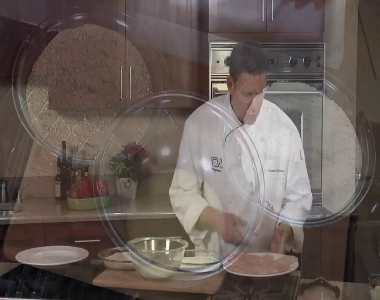

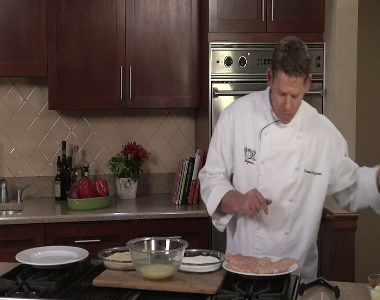

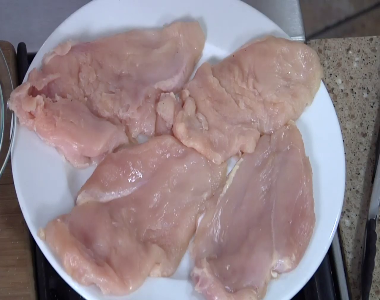

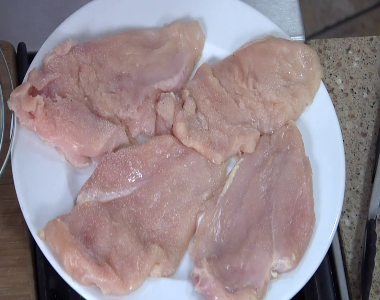

In [101]:
from google.colab.patches import cv2_imshow
video_file = 'video.mp4'  # Replace with the path to your video file

# Define the start and end times in seconds
start_time = df.iloc[video_id]['segment'][0]  ##eval()  # Start time in seconds
end_time = df.iloc[video_id]['segment'][1]    #eval(df.iloc[collection[0][-1]]['segment'])[1]   # End time in seconds

# Open the video file for reading
cap = cv2.VideoCapture(video_file)
captured = []

# Check if the video file opened successfully
if not cap.isOpened():
    print("Error: Could not open video file.")
    exit()

# Get the frames per second (fps) of the video
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Calculate the frame numbers for the start and end times
start_frame = int(start_time * fps)
end_frame = int(end_time * fps)

# Set the video capture position to the start frame
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

# Define the desired low-resolution width and height
low_res_width = 380  # Adjust as needed
low_res_height = 300  # Adjust as needed

# Loop through the frames and display them
count = 0
while cap.isOpened():
  count += 1
  ret, frame = cap.read()

  if count % 50 :
    continue

  if not ret or cap.get(cv2.CAP_PROP_POS_FRAMES) > end_frame:
      break

  # Resize the frame to low resolution
  frame = cv2.resize(frame, (low_res_width, low_res_height))
  captured.append(frame)

  cv2_imshow(frame)

  # You can adjust the frame rate by changing the argument to cv2.waitKey
  if cv2.waitKey(10 // fps) & 0xFF == ord('q'):
      break

# Release the video capture object and close the OpenCV window
cap.release()
cv2.destroyAllWindows()

## vilt

In [79]:
!pip install -q git+https://github.com/huggingface/transformers.git --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import requests
from transformers import ViltProcessor, ViltForQuestionAnswering

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model_vilt = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

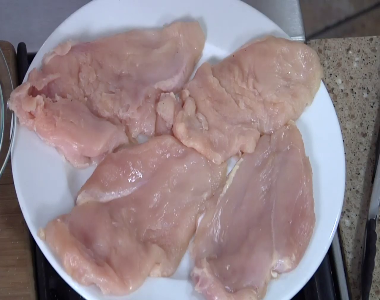

In [127]:
# from PIL import Image
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = captured[2]
text = "what is it ?"
cv2_imshow(captured[2])

In [128]:
type(image)

numpy.ndarray

In [129]:
encoding = processor(image, text, return_tensors="pt")
for k,v in encoding.items():
  print(k, v.shape)

input_ids torch.Size([1, 6])
token_type_ids torch.Size([1, 6])
attention_mask torch.Size([1, 6])
pixel_values torch.Size([1, 3, 384, 480])
pixel_mask torch.Size([1, 384, 480])


In [130]:
# forward pass
outputs = model(**encoding)
logits = outputs.logits
idx = torch.sigmoid(logits).argmax(-1).item()
print("Predicted answer:", model.config.id2label[idx])

Predicted answer: food


In [ ]:
## clip

In [1]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)


/DATA/elidandi_2211ai08/anaconda3/envs/rk/lib/python3.8/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


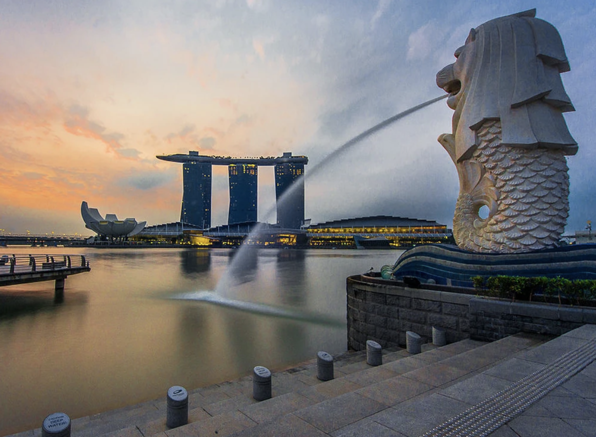

In [2]:
import requests
from PIL import Image

url = 'https://storage.googleapis.com/sfr-vision-language-research/LAVIS/assets/merlion.png' 
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')   
display(image.resize((596, 437)))

In [3]:
image = preprocess(Image.open(requests.get(url, stream=True).raw).convert('RGB')).unsqueeze(0).to(device)
text = clip.tokenize(["water","lion", "skyscrappers","boat"]).to(device)

In [4]:
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print(probs)

[[0.20145422 0.17045102 0.5117714  0.11632331]]
